In [40]:
import pandas as pd
import numpy as np

# Dates de l'index
dates = pd.date_range(start="2016-01-31", end="2016-10-31", freq='M')

# Colonnes MultiIndex
columns = pd.MultiIndex.from_tuples([
    ('HopitalFeatures Total_CHU', 'mean'),
    ('HopitalFeatures Total_CHU', 'sum'),
    ('HopitalFeatures Total_CHU', 'min'),
    ('HopitalFeatures Total_CHU', 'max'),
    ('HopitalFeatures Total_CHU', 'std'),
    ('HopitalFeatures Total_CHU', 'var'),
    # Ajouter d'autres catégories similaires pour les autres statistiques (e.g., 'Dijon', 'HNFC_moving', etc.)
    ('nb_vers_hospit', 'min'),
    ('nb_vers_hospit', 'max'),
    ('nb_vers_hospit', 'std'),
    ('nb_vers_hospit', 'var'),
    ('nb_vers_hospit', 'median'),
    ('HNFC_moving', 'majority_rule')
])

# Données factices (à remplacer par vos propres données)
data = [
    [119.225806, 3696, 88, 151, 14.165003, 200.647312, np.nan, np.nan, np.nan, np.nan, np.nan, 'before'],
    [119.689655, 3471, 96, 149, 11.411471, 130.221675, np.nan, np.nan, np.nan, np.nan, np.nan, 'before'],
    [120.838710, 3746, 100, 150, 12.709830, 161.539785, np.nan, np.nan, np.nan, np.nan, np.nan, 'before'],
    [119.866667, 3596, 101, 156, 11.536250, 133.085057, np.nan, np.nan, np.nan, np.nan, np.nan, 'before'],
    [121.935484, 3780, 104, 151, 12.865809, 165.529032, np.nan, np.nan, np.nan, np.nan, np.nan, 'before'],
    # Ajoutez plus de lignes ici en fonction des données historiques...
    [156.677419, 4857, 128, 191, 15.164404, 229.959140, 28.0, 59.0, 7.033713, 49.473118, 47.0, 'after'],
    [180.666667, 5420, 153, 212, 17.243356, 297.333333, 38.0, 65.0, 6.313277, 39.857471, 50.0, 'after'],
    [180.451613, 5594, 151, 223, 16.343885, 267.122581, 31.0, 61.0, 8.073586, 65.182796, 47.0, 'after'],
    [174.866667, 5246, 152, 208, 14.654018, 214.740230, 40.0, 67.0, 7.156381, 51.213793, 55.0, 'after'],
    [181.709677, 5633, 148, 212, 15.979557, 255.346237, 42.0, 67.0, 7.516004, 56.490323, 54.0, 'after']
]

# Création du DataFrame
df = pd.DataFrame(data, index=dates, columns=columns)

# Affichage du DataFrame
df


/home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/cudf/core/tools/datetimes.py:906: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  offset = pd.tseries.frequencies.to_offset(freq)
/home/maxime/Documents/WORKSPACES/forecasting_models/.venv/lib/python3.10/site-packages/cudf/pandas/fast_slow_proxy.py:25: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  return fn(*args, **kwargs)


HopitalFeatures Total_CHU                                         \
                                mean   sum  min  max        std         var   
2016-01-31                119.225806  3696   88  151  14.165003  200.647312   
2016-02-29                119.689655  3471   96  149  11.411471  130.221675   
2016-03-31                120.838710  3746  100  150  12.709830  161.539785   
2016-04-30                119.866667  3596  101  156  11.536250  133.085057   
2016-05-31                121.935484  3780  104  151  12.865809  165.529032   
2016-06-30                156.677419  4857  128  191  15.164404  229.959140   
2016-07-31                180.666667  5420  153  212  17.243356  297.333333   
2016-08-31                180.451613  5594  151  223  16.343885  267.122581   
2016-09-30                174.866667  5246  152  208  14.654018  214.740230   
2016-10-31                181.709677  5633  148  212  15.979557  255.346237   

           nb_vers_hospit                                     HNFC_moving  
                      min   max       std        var median majority_rule  
2016-01-31            NaN   NaN       NaN        NaN    NaN        before  
2016-02-29            NaN   NaN       NaN        NaN    NaN        before  
2016-03-31            NaN   NaN       NaN        NaN    NaN        before  
2016-04-30            NaN   NaN       NaN        NaN    NaN        before  
2016-05-31            NaN   NaN       NaN        NaN    NaN        before  
2016-06-30           28.0  59.0  7.033713  49.473118   47.0         after  
2016-07-31           38.0  65.0  6.313277  39.857471   50.0         after  
2016-08-31           31.0  61.0  8.073586  65.182796   47.0         after  
2016-09-30           40.0  67.0  7.156381  51.213793   55.0         after  
2016-10-31           42.0  67.0  7.516004  56.490323   54.0         after

In [41]:
# Conversion du MultiIndex des colonnes en un Index simple en concaténant les noms
df.columns = ['__'.join(col).strip() for col in df.columns.values]

# Affichage du DataFrame avec l'index des colonnes simplifié
df

,HopitalFeatures Total_CHU__mean,HopitalFeatures Total_CHU__sum,HopitalFeatures Total_CHU__min,HopitalFeatures Total_CHU__max,HopitalFeatures Total_CHU__std,HopitalFeatures Total_CHU__var,nb_vers_hospit__min,nb_vers_hospit__max,nb_vers_hospit__std,nb_vers_hospit__var,nb_vers_hospit__median,HNFC_moving__majority_rule
2016-01-31,119.225806,3696,88,151,14.165003,200.647312,NaN,NaN,NaN,NaN,NaN,before
2016-02-29,119.689655,3471,96,149,11.411471,130.221675,NaN,NaN,NaN,NaN,NaN,before
2016-03-31,120.838710,3746,100,150,12.709830,161.539785,NaN,NaN,NaN,NaN,NaN,before
2016-04-30,119.866667,3596,101,156,11.536250,133.085057,NaN,NaN,NaN,NaN,NaN,before
2016-05-31,121.935484,3780,104,151,12.865809,165.529032,NaN,NaN,NaN,NaN,NaN,before
2016-06-30,156.677419,4857,128,191,15.164404,229.959140,28.0,59.0,7.033713,49.473118,47.0,after
2016-07-31,180.666667,5420,153,212,17.243356,297.333333,38.0,65.0,6.313277,39.857471,50.0,after
2016-08-31,180.451613,5594,151,223,16.343885,267.122581,31.0,61.0,8.073586,65.182796,47.0,after
2016-09-30,174.866667,5246,152,208,14.654018,214.740230,40.0,67.0,7.156381,51.213793,55.0,after
2016-10-31,181.709677,5633,148,212,15.979557,255.346237,42.0,67.0,7.516004,56.490323,54.0,after


In [194]:
def relative_frequency(series):
    """
    Calcule la fréquence relative (proportion) de chaque catégorie dans une série catégorielle.
    
    Parameters:
    - series (pd.Series): La série catégorielle ou de type objet à analyser.
    
    Returns:
    - pd.Series: Fréquences relatives de chaque catégorie.
    """
    # Compter les occurrences de chaque catégorie
    counts = series.value_counts(normalize=True)
    # print(counts)
    
    # Retourner la proportion (fréquence relative)
    return counts

In [195]:
import pandas as pd
import numpy as np

# Créer une série temporelle avec des catégories
rng = pd.date_range('2023-01-01', periods=100, freq='D')
categories = np.random.choice(['A', 'B', 'C'], size=len(rng))  # Générer des catégories A, B, C
ts = pd.Series(categories, index=rng)

df = ts.to_frame('category')
df['category2'] = np.random.choice(['X', 'Y'], size=len(rng))  # Ajouter une autre catégorie
df['numeric'] = np.random.randn(len(rng))  # Ajouter une colonne numérique

df['category'] = df['category'].astype('category')  # Convertir en catégorie
df['category2'] = df['category2'].astype('category')  # Convertir en catégorie
df


,category,category2,numeric
2023-01-01,B,Y,0.818492
2023-01-02,C,Y,0.658982
2023-01-03,B,X,-0.446678
2023-01-04,C,Y,-0.045935
2023-01-05,B,X,-0.412142
...,...,...,...
2023-04-06,B,X,0.460707
2023-04-07,B,X,0.154461
2023-04-08,A,X,-0.408040
2023-04-09,A,X,1.185303


In [196]:

"""
Agrège les données d'un DataFrame selon une fréquence spécifiée et un dictionnaire d'agrégations
basé sur le type de données.

Parameters:
- data (pd.DataFrame): Le DataFrame contenant les données temporelles.
- freq (str): La fréquence d'agrégation (e.g., 'D' pour journalier, 'H' pour horaire, etc.).
- agg_dict (dict): Dictionnaire où chaque clé est un type de donnée (e.g., 'float', 'int') et la valeur est une liste de fonctions d'agrégation.

Returns:
- pd.DataFrame: Le DataFrame agrégé avec un MultiIndex pour les colonnes.
"""

# Vérifier que le DataFrame est fourni
data = df
agg_dict = {'number': ['mean', 'sum', 'min', 'max', 'std', 'var', 'median'], 'category': [relative_frequency]}
freq = '1ME'

# Vérifier que le DataFrame a un index de type DateTime
if not isinstance(data.index, pd.DatetimeIndex):
    raise ValueError("Le DataFrame doit avoir un index de type DateTime.")

# Créer un dictionnaire pour stocker les agrégations par colonne
column_agg_dict = {}

# Pour chaque type dans agg_dict, on applique les fonctions d'agrégation aux colonnes correspondantes
for dtype, funcs in agg_dict.items():
    matching_columns = data.select_dtypes(include=[dtype]).columns
    for col in matching_columns:
        column_agg_dict[col] = funcs

column_agg_dict

{'numeric': ['mean', 'sum', 'min', 'max', 'std', 'var', 'median'],
 'category': [<function __main__.relative_frequency(series)>],
 'category2': [<function __main__.relative_frequency(series)>]}

In [197]:
# Fonction d'application unifiée pour gérer les différentes fonctions d'agrégation
def unified_apply_func(series, funcs):
    """
    Applique une liste de fonctions à une série et retourne une Series ou un DataFrame.
    """
    results = {}
    for func in funcs:
        if callable(func):
            result = func(series)
            if isinstance(result, pd.Series):
                # Renommer les résultats de la série pour les inclure dans le MultiIndex
                results.update(result.rename(lambda x: f"{func.__name__}__{x}"))
            else:
                results[func.__name__] = result
        else:
            result = getattr(series, func)()
            results[func] = result
    return pd.Series(results)

# Appliquer les agrégations à chaque groupe
def apply_aggregations(group):
    aggregated = {}
    for col, funcs in column_agg_dict.items():
        # print(group[col])
        aggregated[col] = unified_apply_func(group[col], funcs)
    
        concat = pd.concat(aggregated, axis=0)
    return concat

In [198]:
# Grouper les données par la fréquence spécifiée
grouper = pd.Grouper(freq=freq)
grouped_data = data.groupby(grouper)
# print(grouped_data)

# grouped_data = data.resample(freq)

# Appliquer les agrégations
aggregated_df = grouped_data.apply(apply_aggregations)

# # Réorganiser les colonnes pour avoir un MultiIndex
# def create_multiindex_from_columns(columns):
#     new_columns = []
#     for col in columns:
#         if '__' in col:
#             split_col = col.split('__')
#             if len(split_col) == 3:
#                 new_columns.append((split_col[0], split_col[1], split_col[2]))
#             else:
#                 new_columns.append((split_col[0], split_col[1], ''))
#         else:
#             new_columns.append((col, 'value', ''))
#     return pd.MultiIndex.from_tuples(new_columns, names=['Column', 'Aggregation', 'Category'])

# aggregated_df.columns = create_multiindex_from_columns(aggregated_df.columns)

numeric                                                    \
                mean       sum       min       max       std       var   
2023-01-31  0.146292  4.535040 -2.054567  1.745341  0.917025  0.840935   
2023-02-28 -0.265566 -7.435860 -1.950977  1.021036  0.896555  0.803811   
2023-03-31  0.105986  3.285580 -1.749994  2.185119  1.033329  1.067769   
2023-04-30  0.162785  1.627855 -2.070219  1.969639  1.268761  1.609754   

                                  category                        \
              median relative_frequency__C relative_frequency__B   
2023-01-31  0.462642              0.451613              0.354839   
2023-02-28 -0.352518              0.250000              0.392857   
2023-03-31  0.159821              0.290323              0.225806   
2023-04-30  0.123715              0.200000              0.400000   

                                             category2                        
           relative_frequency__A relative_frequency__X relative_frequency__Y  
2023-01-31              0.193548              0.516129              0.483871  
2023-02-28              0.357143              0.607143              0.392857  
2023-03-31              0.483871              0.516129              0.483871  
2023-04-30              0.400000              0.800000              0.200000

In [202]:
agg_df = aggregated_df.to_frame().unstack(level=[1, 2]).droplevel(0, axis=1)

<Axes: title={'center': 'Numeric Data'}>

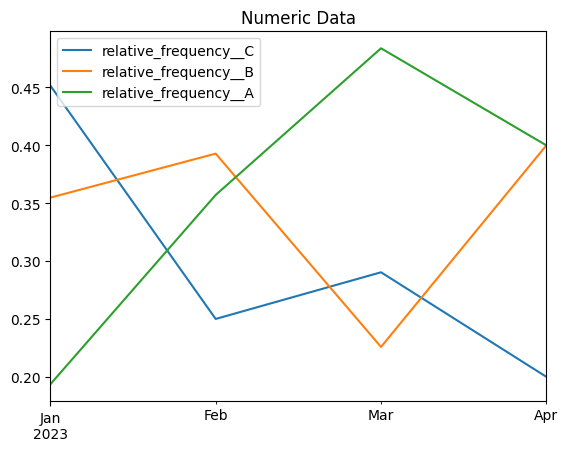

In [207]:
agg_df["category"].plot(kind="line", title="Numeric Data", legend=True)

In [199]:
# aggregated_df = aggregated_df.to_frame()
# aggregated_df

In [200]:
# df_agg = aggregated_df.unstack(level=[1, 2])
# df_agg

In [201]:
# df_agg.droplevel(0, axis=1)

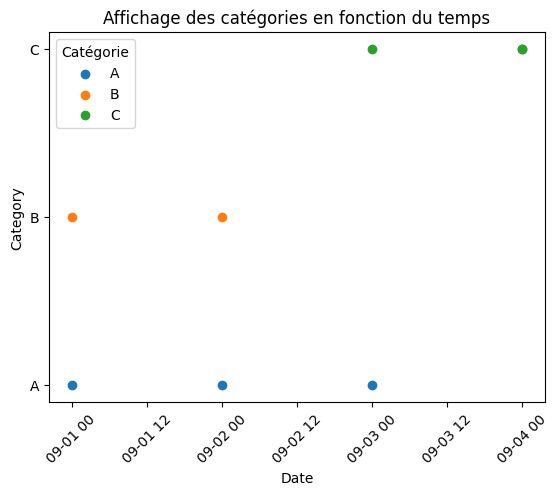

In [209]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de DataFrame
data = {'date': ['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04', 
                 '2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04'],
        'category': ['A', 'B', 'A', 'C', 'B', 'A', 'C', 'C']}

df = pd.DataFrame(data)

# Conversion de la colonne 'date' en datetime si ce n'est pas déjà fait
df['date'] = pd.to_datetime(df['date'])

# Tracer des points pour chaque catégorie en fonction de la date
for category in df['category'].unique():
    subset = df[df['category'] == category]
    plt.scatter(subset['date'], [category] * len(subset), label=category)

plt.xlabel('Date')
plt.ylabel('Category')
plt.title('Affichage des catégories en fonction du temps')
plt.legend(title="Catégorie")
plt.xticks(rotation=45)  # Rotation des dates pour une meilleure lisibilité
plt.show()

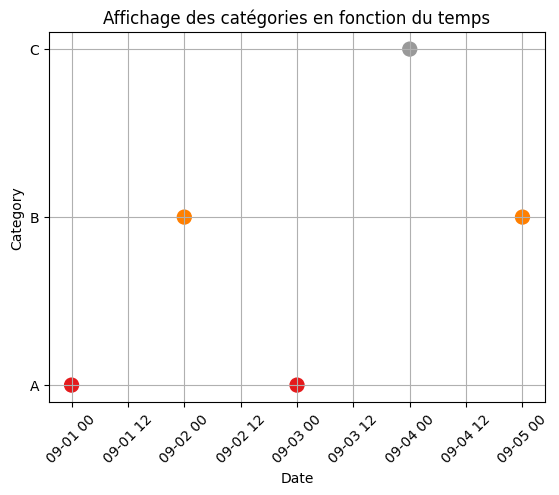

In [210]:
import pandas as pd
import matplotlib.pyplot as plt

# Exemple de DataFrame : une seule catégorie par jour
data = {
    'date': ['2023-09-01', '2023-09-02', '2023-09-03', '2023-09-04', '2023-09-05'],
    'category': ['A', 'B', 'A', 'C', 'B']
}

df = pd.DataFrame(data)

# Conversion de la colonne 'date' en datetime
df['date'] = pd.to_datetime(df['date'])

# Mapping des catégories à des valeurs numériques (pour les afficher sur l'axe Y)
categories = df['category'].unique()
category_mapping = {category: idx for idx, category in enumerate(categories)}

# Remplacement des catégories par des valeurs numériques pour l'affichage
df['category_numeric'] = df['category'].map(category_mapping)

# Tracé du graphique avec les catégories en fonction des dates
plt.scatter(df['date'], df['category_numeric'], c=df['category_numeric'], cmap='Set1', s=100)

# Remplacer les valeurs numériques par les noms de catégories sur l'axe Y
plt.yticks(ticks=list(category_mapping.values()), labels=list(category_mapping.keys()))

plt.xlabel('Date')
plt.ylabel('Category')
plt.title('Affichage des catégories en fonction du temps')
plt.xticks(rotation=45)  # Rotation des dates pour une meilleure lisibilité
plt.grid(True)
plt.show()